In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import shutil
from shutil import copyfile
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from scipy import ceil
import scipy

In [14]:
source_path = '/content/drive/MyDrive/Data set FIX2'


list=[]

for i in os.listdir(source_path):
    source_path_item = os.path.join(source_path, i)
    n = 0
    for j in os.listdir(source_path_item):
        if j[-3:] == "jpg" or j[-3:] == "gif":
            im = Image.open(os.path.join(source_path_item, j)).convert("RGB")
            im.save(os.path.join(source_path_item, j[:-3]+'jpeg'))

            os.remove(os.path.join(source_path_item, j))
            n += 1

    print("Convert Successful")
    print("Converted image =",n)
    print(f"There are {len(os.listdir(source_path_item))} images of", i + ".\n")
    list.append(i)

Convert Successful
Converted image = 0
There are 100 images of Zoro.

Convert Successful
Converted image = 0
There are 103 images of asuka.

Convert Successful
Converted image = 0
There are 120 images of kurumi.

Convert Successful
Converted image = 0
There are 343 images of Ayaka.

Convert Successful
Converted image = 0
There are 342 images of Kokomi.



In [15]:
root_dir = 'Animeee'

if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

for i in list:
    os.makedirs(os.path.join(root_dir,"train",i))
    os.makedirs(os.path.join(root_dir,"validation",i))

In [16]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

  random_sample=random.sample(os.listdir(SOURCE_DIR),len(os.listdir(SOURCE_DIR)))

  size=int(len(random_sample)*SPLIT_SIZE)

  target=TRAINING_DIR
  i=0

  for item in random_sample:

    item_source = os.path.join(SOURCE_DIR, item)

    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else:
      copyfile(item_source, os.path.join(target, item))
      i += 1

    if i == size:
      target = VALIDATION_DIR

In [17]:
train_dir = os.path.join(root_dir,"train")
val_dir = os.path.join(root_dir,"validation")

for i in os.listdir(train_dir):
  path = os.path.join(train_dir,i)
  if len(os.listdir(path))>0:
    for file in os.scandir(path):
      os.remove(file.path)

for i in os.listdir(val_dir):
  path = os.path.join(val_dir,i)
  if len(os.listdir(path))>0:
    for file in os.scandir(path):
      os.remove(file.path)

split_size = .8

for i in list:
  split_data(os.path.join(source_path,i), os.path.join(train_dir, i), os.path.join(val_dir, i), split_size)
  print("Split", i, "Successful")
  print(f"There are {len(os.listdir(os.path.join(train_dir,i)))} images of", i + " for training.")
  print(f"There are {len(os.listdir(os.path.join(val_dir,i)))} images of", i + " for validation.\n")

Split Zoro Successful
There are 80 images of Zoro for training.
There are 20 images of Zoro for validation.

Split asuka Successful
There are 82 images of asuka for training.
There are 21 images of asuka for validation.

Split kurumi Successful
There are 96 images of kurumi for training.
There are 24 images of kurumi for validation.

Split Ayaka Successful
There are 274 images of Ayaka for training.
There are 69 images of Ayaka for validation.

Split Kokomi Successful
There are 273 images of Kokomi for training.
There are 69 images of Kokomi for validation.



In [18]:
TRAINING_DIR = "/content/Animeee/train"
TESTING_DIR = "/content/Animeee/validation"
#train_val_generators
def train_val_generators(TRAINING_DIR, TESTING_DIR):

  train_data = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_data.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(299,299))

  # Rescaling Image
  testing_data = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  testing_generator = testing_data.flow_from_directory(directory=TESTING_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(299,299))
  ### END CODE HERE
  return train_generator, testing_generator

In [19]:
# Check Generator Working or not
train_generator, testing_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)

Found 805 images belonging to 5 classes.
Found 203 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.models import Model

base_model = Xception(weights='imagenet', input_shape = (299,299,3), include_top=False, pooling = 'avg')

  # Flatten
x = base_model.output
  # Add Full connected layer
x = Dense(32, activation='relu')(x)
  # Adding dropout layer to prevent overfit
x = Dropout(rate=.2)(x)
  # ouput layer for 5 categories that we train
predictions = Dense(5, activation='softmax')(x)

  # Training Model
model = Model(inputs=base_model.input, outputs=predictions)

#freeze all trainable layer
for layer in base_model.layers:
  layer.trainable = False

#Compile the model
model.compile(optimizer='adam',
          loss='categorical_crossentropy',
              metrics=['accuracy'])

#unfreeze several layer from trainable layer
for layer in model.layers[:116]:
    layer.trainable = False
for layer in model.layers[116:]:
    layer.trainable = True

model.summary();
# Train the model
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=testing_generator)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'

In [ ]:
def plot_train_history(history):
    # Summarize history for accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()

    plt.plot(epochs,loss, 'r', label='train_loss')
    plt.plot(epochs,val_loss, 'b', label='test_loss')
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc=0)
    plt.show()



In [ ]:
model.save('modelanimeB.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_json = model.to_json()
with open("model_tf_learning_fix.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("weight_tf_learning_fix.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
import numpy as np
label_names = {0: 'Ayaka', 1: 'Kokomi', 2: 'Zoro', 3: 'Asuka', 4: 'kurumi'}
def run_prediction():
     n = 331
     plt.figure(figsize=(15, 15))
     for i in range(9):
         plt.subplot(n)
         idx = random.randint(0, len(testing_generator)-1)
         predict = model.predict(testing_generator[idx][0])
         plt.imshow(testing_generator[idx][0][0])
         plt.title(np.argmax(predict))
         n += 1
run_prediction()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# load and evaluate a saved model
from keras.models import load_model

# load model
model = load_model('modelanimeB.h5')

In [ ]:
# new_model= tf.keras.models.load_model(model)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model.
with open("model_tflite.tflite", 'wb') as f:
  f.write(tflite_model)
  print("Saved model to disk")

Saved model to disk


1/1 [==============================] - 0s 35ms/step
Hasil Klasifikasi Gambar:  Ayaka
0.89484316


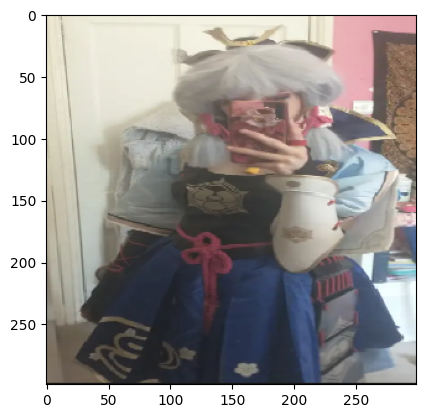

In [ ]:
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt


path = '/content/drive/MyDrive/ayaka miror.png'
#load image make the size into the target size from training gen
img = image.load_img(path, target_size=(299, 299))
#convert image to array and rescale it to 1./255
x = image.img_to_array(img)/255

#change shape of the image
x = np.expand_dims(x, axis=0)

# prediksi model
classes = model.predict(x,batch_size=10)
# check the array of classes to determine which array the result of prediction
prediction = np.where(classes==np.max(classes))
# checking from the 2 dimesion array from prediction and find the max probability
persentase = str(np.max(classes))

label_names = ["Ayaka", "Kokomi", "Zoro", "Asuka", "kurumi"]
prediction_name = label_names[np.argmax(classes[0])]

print("Hasil Klasifikasi Gambar: " ,prediction_name)
print(persentase)

# if run from local can use this
# prediksi_indices=train_generator.class_indices
# prediksi = np.argmax(classes)
# for key, value in prediksi_indices.items():
#     if value==prediksi:
#       print(key)

plt.imshow(img)
# print(classes)